# Load Forecasting

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import datetime
import pandas as pd
import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

from utils import *
from latexify import *
golden_mean = (np.sqrt(5) - 1.0) / 2.0  # Aesthetic ratio

## Train and test data sets

In [2]:
# Read data from CSV files and create a pandas series
csv_files = ["data/load_2020.csv", "data/load_2021.csv", "data/load_2022.csv"]
df_list = []

for file in csv_files:
    temp_df = pd.read_csv(file, index_col=0)
    temp_df.index = pd.to_datetime(temp_df.index, format='%Y-%m-%d %H:%M:%S')
    df_list.append(temp_df)

df = pd.concat(df_list)
load_data = df["Load (kWh)"]

load_data.to_pickle("data/load_data.pickle")

# Split data into train set and test set
train = load_data[load_data.index.year <= 2021]
test = load_data[load_data.index.year > 2021]

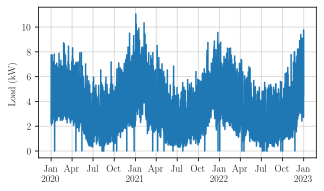

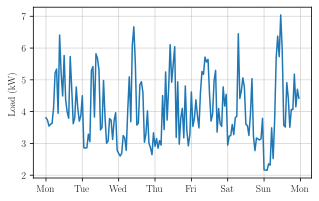

In [3]:
class JanYearDateFormatter(mdates.DateFormatter):
    def __init__(self, fmt='%b'):
        super().__init__(fmt)

    def __call__(self, x, pos=0):
        dt = mdates.num2date(x)
        if dt.month == 1:
            return dt.strftime('%b\n%Y')
        else:
            return dt.strftime('%b')

# Plot load data for the whole 3 years
latexify(5)
fig, ax = plt.subplots()
load_data.plot(ax=ax, color="tab:blue")
plt.ylabel("Load (kW)")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(JanYearDateFormatter())
plt.xticks(rotation=0, ha='center')

plt.savefig("figures/load_three_years.pdf")
    
# Plot load data for 1 week in January 2022
latexify(5)
fig, ax = plt.subplots()
week_data = load_data.loc['2022-01-10':'2022-01-16']
ax.plot(week_data.values, color="tab:blue")
ax.set_ylabel("Load (kW)")
ax.set_xticks(np.arange(0, 24 * 7 + 1, 24))
ax.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun", "Mon"])

plt.savefig("figures/load_one_week.pdf")

## Seasonal baseline forecast

In [4]:
PERIODS = [period / harmonic for harmonic in [1, 2, 3, 4] for period in [24, 24*7, 24*365]]
PERIODS = [3600 * period for period in PERIODS]

def featurize_for_baseline(data, periods):
    seconds = data.index.astype(np.int64) / 1E9
    X = np.zeros((len(seconds), 1 + 2 * len(periods)))
    trig_functions = [np.sin, np.cos]

    for idx, (period, trig) in enumerate([(p, t) for p in periods for t in trig_functions]):
        X[:, idx] = trig(2 * np.pi * seconds / period)

    X[:, -1] = np.ones(len(seconds))
    y = data.values
    return X, y

# Featurize train and test data
Xtr, ytr = featurize_for_baseline(train, PERIODS)
Xte, yte = featurize_for_baseline(test, PERIODS)

def fit_seasonal_baseline(X, y, reg_weight=0.001):
    params = cp.Variable(X.shape[1])
    objective = cp.Minimize(cp.sum_squares(X @ params - y) + reg_weight * cp.sum_squares(params))
    problem = cp.Problem(objective)
    problem.solve()
    return params.value

# Fit seasonal baseline to train data
baseline_params = fit_seasonal_baseline(Xtr, ytr)

def predict_with_baseline(X, parameters):
    return X @ parameters

# Make predictions and calculate RMSE
train_baseline = predict_with_baseline(Xtr, baseline_params)
test_baseline = predict_with_baseline(Xte, baseline_params)
def RMSE(array):
    return np.sqrt(np.mean(array**2))
train_rmse = RMSE(train.values - train_baseline)
test_rmse = RMSE(test.values - test_baseline)

print('Baseline train RMSE', train_rmse)
print('Baseline test RMSE', test_rmse)

# Create prediction Series
train_baseline_series = pd.Series(index=train.index, data=train_baseline)
test_baseline_series = pd.Series(index=test.index, data=test_baseline)
baseline = pd.concat([train_baseline_series, test_baseline_series])


# Extend baseline to 2023
date_range_2023 = pd.date_range(start='2023-01-01 00:00:00', end='2023-12-31 23:00:00', freq='H')
dummy_series_2023 = pd.Series(index=date_range_2023, dtype='float64')
X_2023, _ = featurize_for_baseline(dummy_series_2023, PERIODS)
baseline_2023 = predict_with_baseline(X_2023, baseline_params)
baseline_2023_series = pd.Series(index=date_range_2023, data=baseline_2023)
baseline = pd.concat([baseline, baseline_2023_series])

baseline.to_pickle("data/load_baseline.pickle")

Baseline train RMSE 1.037568377708409
Baseline test RMSE 1.055145548495499


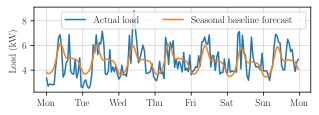

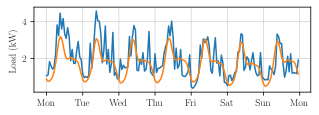

In [5]:
# Plot load and seasonal baseline for first week of January 2022
latexify(fig_width=5, fig_height=5*golden_mean/2)
fig, ax = plt.subplots()
week_load_data = test.loc['2022-01-03':'2022-01-09']
week_baseline_data = test_baseline_series.loc['2022-01-03':'2022-01-09']
plt.plot(week_load_data.values, color="tab:blue", label="Actual load")
plt.plot(week_baseline_data.values, color="tab:orange", label="Seasonal baseline forecast")
plt.legend(ncol=2)
plt.ylabel("Load (kW)")
ax.set_xticks(np.arange(0, 24 * 7 + 1, 24))
ax.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun", "Mon"])

plt.savefig("figures/baseline_jan.pdf")

# Plot load and seasonal baseline for first week of July 2022
latexify(fig_width=5, fig_height=5*golden_mean/2)
fig, ax = plt.subplots()
week_load_data = test.loc['2022-06-06':'2022-06-12']
week_baseline_data = test_baseline_series.loc['2022-07-04':'2022-07-10']
plt.plot(week_load_data.values, color="tab:blue")
plt.plot(week_baseline_data.values, color="tab:orange")
plt.ylabel("Load (kW)")
ax.set_xticks(np.arange(0, 24 * 7 + 1, 24))
ax.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun", "Mon"])

plt.savefig("figures/baseline_jul.pdf")

## Auto-regressive residual forecast

0.9112003922439179


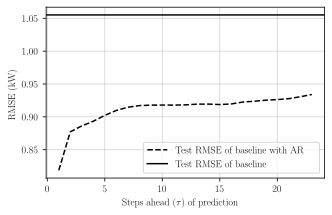

In [25]:
train_residual = train - train_baseline
test_residual = test - test_baseline

pd.to_pickle(train_residual, "data/train_residual.pickle")


M, L = 24, 23

def featurize_residual(obs, M, L):
    X = np.zeros((len(obs) - M - L+1, M))
    for i in range(M):
        X[:,i] = obs[M-i-1:-L-i]
        
    y = np.zeros((len(obs) - M - L+1, L))
    for i in range(L):
        y[:,i] = obs[M+i:len(obs)+1-L+i]
        
    return X, y

def fit_residual(X, y):
    pinv = np.linalg.inv(X.T @ X) @ X.T
    params = pinv @ y
    return params

# Featurize and fit residuals
Xtr, ytr = featurize_residual(train_residual, M, L)
Xte, yte = featurize_residual(test_residual, M, L)
AR_params = fit_residual(Xtr, ytr)

pd.to_pickle(AR_params, "data/AR_params.pickle")

# Calculate predicted residuals
train_predicted_residuals = Xtr @ AR_params
test_predicted_residuals = Xte @ AR_params

# Define RMSE function for lags
def lag_RMSE(y, hat_y):
    return np.sqrt(np.sum((y - hat_y)**2, 0)/len(y))

# Plot test RMSEs for baseline with AR and baseline
latexify(fig_width=5)
plt.figure()
plt.plot(range(1,L+1), lag_RMSE(yte, test_predicted_residuals), 'k--')
plt.axhline(RMSE(test.values - test_baseline), color='k')
plt.legend(['Test RMSE of baseline with AR', 'Test RMSE of baseline'], loc='lower right')
plt.xlabel('Steps ahead ($\\tau$) of prediction')
plt.ylabel('RMSE (kW)')

plt.savefig("figures/RMSE.pdf")

print(np.mean(lag_RMSE(yte, test_predicted_residuals)))

## Forecast comparison for a test day

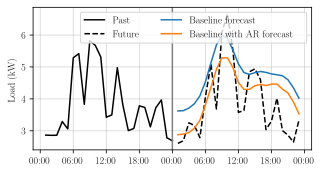

In [7]:
test_day = datetime.datetime(2022, 1, 12)
past = test[test.index <= test_day][-M:]
past_baseline = test_baseline[test.index <= test_day][-M:]

future = test[test.index > test_day][:L]
future_baseline = test_baseline[test.index > test_day][:L]

past_res = past - past_baseline
future_res_prediction = past_res.values @ AR_params
future_res = future - future_baseline

latexify(5, 5*golden_mean/1.2)
plt.figure()

# Plot past data
plt.plot(past.index, past.values, color="k", label="Past")
plt.axvline(test_day, color='gray')

# Plot future data
plt.plot(future.index, future.values, color="k", linestyle="dashed",label="Future")
plt.plot(future.index, future_baseline, color="tab:blue", label="Baseline forecast")
plt.plot(future.index, future_baseline + future_res_prediction, color="tab:orange", label="Baseline with AR forecast")

plt.ylabel("Load (kW)")
plt.legend(ncol=2)

# Format x-axis datetime
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.savefig("figures/forecast_comparison.pdf")